In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np

# Collect Data
data = pd.read_csv("Fish.csv")

In [2]:
# Visualize the data

# how does data look like
data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  159 non-null    object 
 1   Weight   159 non-null    float64
 2   Length1  159 non-null    float64
 3   Length2  159 non-null    float64
 4   Length3  159 non-null    float64
 5   Height   159 non-null    float64
 6   Width    159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


In [4]:
# Get count for each species
data.Species.value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

In [5]:
# Does the data have missing values?
data.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

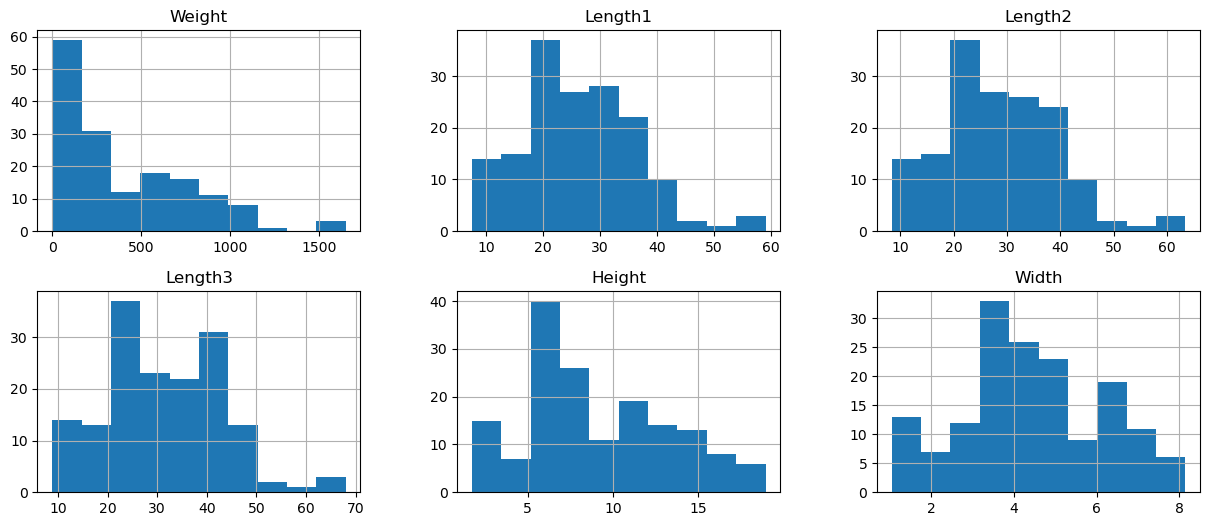

In [6]:
# What is the distribution of the numerical features?
data_num = data.drop(columns=["Species"])

fig, axes = plt.subplots(len(data_num.columns)//3, 3, figsize=(15, 6))
i = 0
for triaxis in axes:
    for axis in triaxis:
        data_num.hist(column = data_num.columns[i], ax=axis)
        i = i+1

In [7]:
# What is the distribution of the target variable(Weight) with respect to fish Species?
sns.displot(
  data=data,
  x="Weight",
  hue="Species",
  kind="hist",
  height=6,
  aspect=1.4,
  bins=15
)
plt.show()
sns.pairplot(data, kind='scatter', hue='Species')

AttributeError: module 'seaborn' has no attribute 'displot'

In [8]:
# What is a correlation between the target variable and features?
plt.figure(figsize=(7,6))
corr = data_num.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)
plt.show()

AttributeError: module 'seaborn' has no attribute 'heatmap'

<Figure size 700x600 with 0 Axes>

In [ ]:
# Clean the data
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler 

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

ct = make_column_transformer(
    (StandardScaler(),['Length1','Length2','Length3','Height','Width']), #turn all values from 0 to 1
    (OneHotEncoder(handle_unknown="ignore"), ["Species"])
)
#create X and y values
data_cleaned =   data.drop("Weight",axis=1)
y = data['Weight']

x_train, x_test, y_train, y_test = train_test_split(data_cleaned,y, test_size=0.2, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
X_train_normal = pd.DataFrame(ct.fit_transform(x_train))
X_test_normal = pd.DataFrame(ct.transform(x_test))

(127, 6) (32, 6) (127,) (32,)


In [ ]:
# Train the models
def models_score(model_name, train_data, y_train, val_data,y_val):
    model_list = ["Linear_Regression","Lasso_Regression","Ridge_Regression"]
    #model_1
    if model_name=="Linear_Regression":
        reg = LinearRegression()
    #model_2
    elif model_name=="Lasso_Regression":
      reg = Lasso(alpha=0.1,tol=0.03)
        
    #model_3
    elif model_name=="Ridge_Regression":
        reg = Ridge(alpha=1.0)
    else:
        print("please enter correct regressor name")
        
    if model_name in model_list:
        reg.fit(train_data,y_train)
        pred = reg.predict(val_data)
     
        score_MSE = mean_squared_error(pred, y_val)
        score_MAE = mean_absolute_error(pred, y_val)
        score_r2score = r2_score(pred, y_val)
        return round(score_MSE,2), round(score_MAE,2), round(score_r2score,2)
model_list = ["Linear_Regression","Lasso_Regression","Ridge_Regression"]
result_scores = []
for model in model_list:
    score = models_score(model,X_train_normal,y_train, X_test_normal,y_test)
    result_scores.append((model, score[0], score[1],score[2]))
    print(model,score)

Linear_Regression (7007.38, 65.3, 0.94)
Lasso_Regression (7720.81, 66.51, 0.93)
Ridge_Regression (7610.02, 69.12, 0.93)


In [ ]:
# Evaluate
df_result_scores = pd.DataFrame(result_scores,columns=["model","mse","mae","r2score"])
df_result_scores

,model,mse,mae,r2score
0,Linear_Regression,7007.38,65.30,0.94
1,Lasso_Regression,7720.81,66.51,0.93
2,Ridge_Regression,7610.02,69.12,0.93


In [ ]:
# Step 6: Hyperparameter tuning
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
space = dict()
space['solver'] = ['svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 50)
model = Ridge()
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
search = RandomizedSearchCV(model, space, n_iter=100, 
     scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv,                 random_state=42)
result = search.fit(X_train_normal, y_train)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was

Best Score: -75.7335238921262
Best Hyperparameters: {'alpha': 0.2890639228894638, 'solver': 'sag'}


/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/justinluo/opt/anaconda3/envs/fishDetection/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Fit these hyperparameters
reg = Ridge(alpha=0.24171039031894245, solver ="sag" )
reg.fit(X_train_normal,y_train)
pred = reg.predict(X_test_normal)
score_MSE = mean_squared_error(pred, y_test)
score_MAE = mean_absolute_error(pred, y_test)
score_r2score = r2_score(pred, y_test)
to_append = ["Ridge_hyper_tuned",round(score_MSE,2), round(score_MAE,2), round(score_r2score,2)]
df_result_scores.loc[len(df_result_scores)] = to_append
df_result_scores

,model,mse,mae,r2score
0,Linear_Regression,7007.38,65.30,0.94
1,Lasso_Regression,7720.81,66.51,0.93
2,Ridge_Regression,7610.02,69.12,0.93
3,Ridge_hyper_tuned,7462.21,66.31,0.94


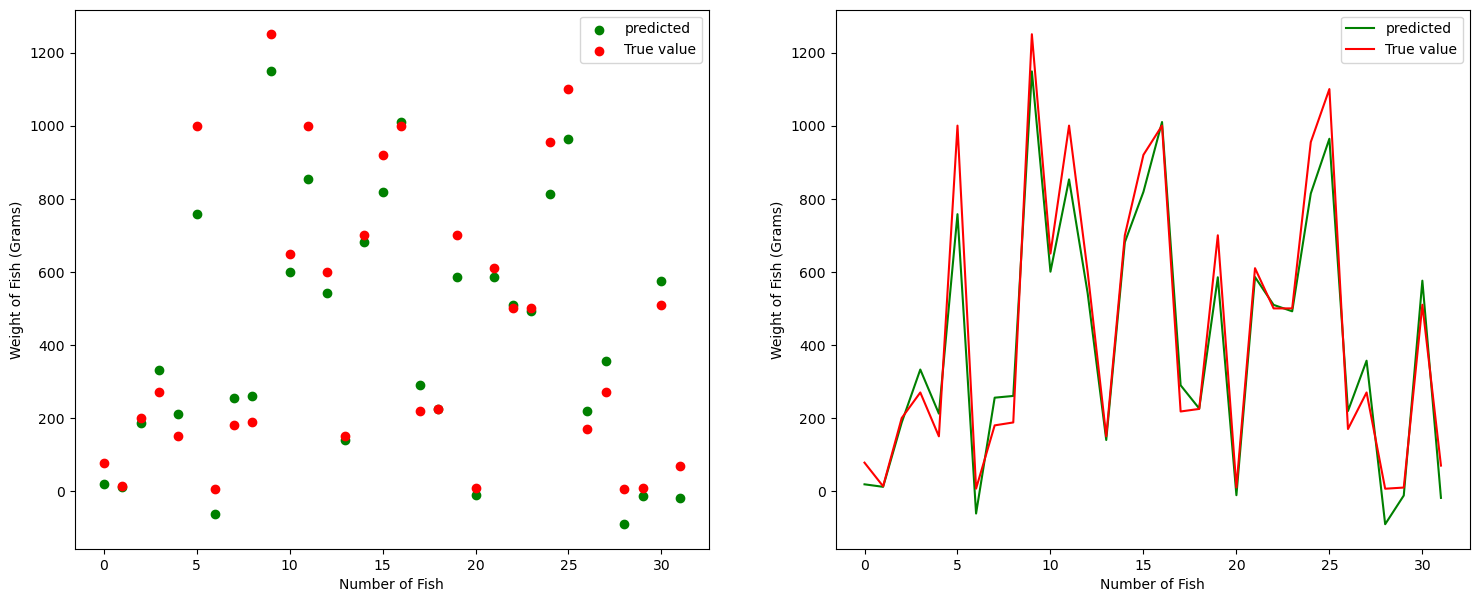

Overall Margin of Error Percentage: 14.704114060054657


In [ ]:
reg = LinearRegression() # Choosing the best model and prediction
reg.fit(X_train_normal,y_train)
pred = reg.predict(X_test_normal)
plt.figure(figsize=(18,7))
plt.subplot(1, 2, 1) # row 1, col 2 index 1
plt.scatter(range(0,len(X_test_normal)), pred,color="green",label="predicted") # number of fish in test data
plt.scatter(range(0,len(X_test_normal)), y_test,color="red",label="True value") # weight (grams)
plt.xlabel("Number of Fish")
plt.ylabel("Weight of Fish (Grams)")
plt.legend()

plt.subplot(1, 2, 2) # index 2
plt.plot(range(0,len(X_test_normal)), pred,color="green",label="predicted") # number of fish in test data
plt.plot(range(0,len(X_test_normal)), y_test,color="red",label="True value") # weight (grams)
plt.xlabel("Number of Fish")
plt.ylabel("Weight of Fish (Grams)")
plt.legend()
plt.show()

residuals = y_test - pred
absolute_residuals = np.abs(residuals)
mae = np.mean(absolute_residuals)
mean_y_test = np.mean(y_test)
percentage_error = (mae / mean_y_test) * 100

print("Overall Margin of Error Percentage:", percentage_error)